In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246767 sha256=3b341fb0907ab10c2b76374e46d7f991423e42951187297d13cc1066ff7c724b
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

Fri Aug  2 21:16:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import pandas as pd
import re
import fasttext
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import nltk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_sample_weight
import os, sys
import time
import logging
import xml.etree.ElementTree as ET
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_excel('/content/drive/MyDrive/daset/Daset_indo.xlsx')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Entitas  3669 non-null   object
 1   Label    3502 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB


In [ ]:
train_df.head(20)

,Entitas,Label
0,ingredients,O
1,wheat,B-ingredients
2,flour,I-ingredients
3,sugar,B-ingredients
4,shortening,B-ingredients
5,vegetable,B-ingredients
6,oil,I-ingredients
7,cocoa,B-ingredients
8,powder,I-ingredients
9,corn,B-ingredients


In [ ]:
# buat index untuk kalimat data train
sentence_index = 0
sentence_indices = []
for word in train_df['Entitas']:
    if word == '.':
        sentence_index += 1
    sentence_indices.append(sentence_index)

train_df.insert(0, 'Sentence Index', sentence_indices)

In [ ]:
train_df

,Sentence Index,Entitas,Label
0,0,ingredients,O
1,0,wheat,B-ingredients
2,0,flour,I-ingredients
3,0,sugar,B-ingredients
4,0,shortening,B-ingredients
...,...,...,...
3665,165,e1505,B-ingredients
3666,165,e1510,B-ingredients
3667,165,e1518,B-ingredients
3668,165,e1520,B-ingredients


In [ ]:
train_df.isna().sum()

,0
Sentence Index,0
Entitas,1
Label,168


In [ ]:
train_df.dropna(inplace=True)

In [ ]:
train_df['Label'].unique()

array(['O', 'B-ingredients', 'I-ingredients'], dtype=object)

<ipython-input-15-ab3b621bfa88>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=train_df['Label'], palette="Set2")


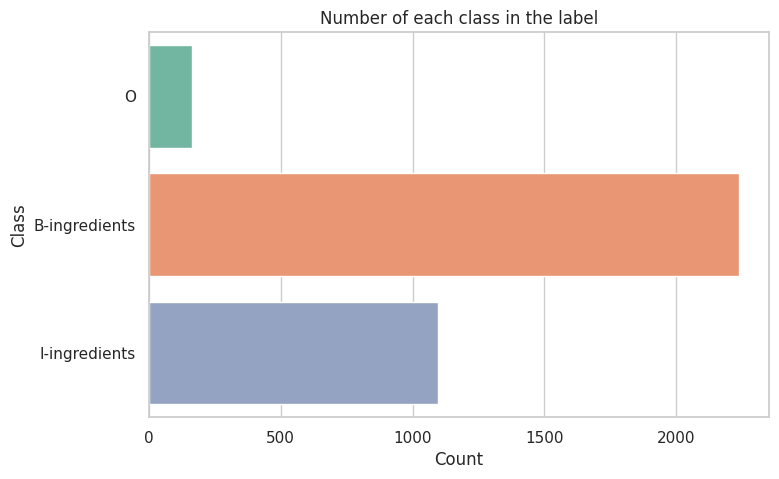

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh data frame, pastikan Anda sudah memilikinya
# train_df = ...

# Setel tata letak plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot countplot horizontal
ax = sns.countplot(y=train_df['Label'], palette="Set2")

plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Number of each class in the label")
plt.show()

<ipython-input-16-f15671790997>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=train_df['Label'], palette="Set2")


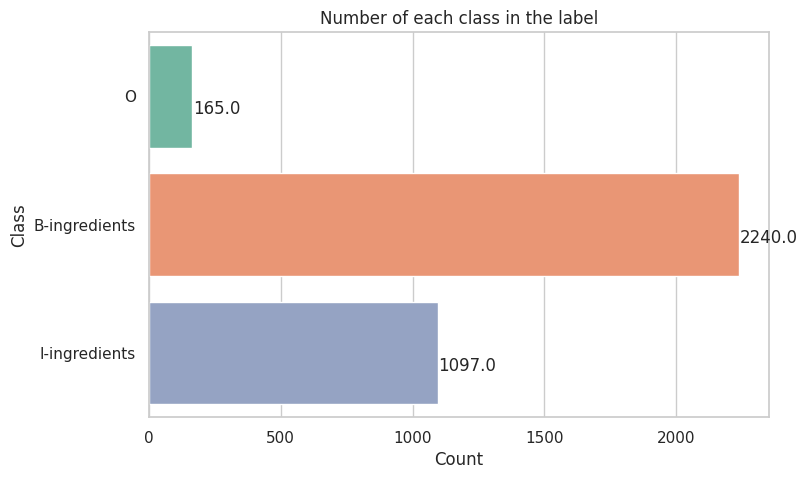

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contoh data frame, pastikan Anda sudah memilikinya
# train_df = ...

# Setel tata letak plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot countplot horizontal
ax = sns.countplot(y=train_df['Label'], palette="Set2")

# Tambahkan teks jumlah di sebelah setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 1, p.get_y() + 0.5), ha='left', va='center')

plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Number of each class in the label")
plt.show()

In [ ]:
len(train_df['Label'])

3502

In [ ]:
print(f"{train_df.shape}")

(3502, 3)


In [ ]:
sentences = train_df["Sentence Index"].values[-1] + 1

In [ ]:
def get_dict_map(train_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = [''] + list(set(train_df['Entitas'].to_list()))
    else:
        vocab = [''] + list(set(train_df['Label'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(train_df, 'token')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [ ]:
idx2tag

{0: '', 1: 'B-ingredients', 2: 'I-ingredients', 3: 'O'}

In [ ]:
idx2token

{0: '',
 1: 'e575',
 2: 'e1505',
 3: 'bicarbonate',
 4: 'melted',
 5: 'e412',
 6: 'gluten',
 7: 'asiago',
 8: 'acscorbyl',
 9: 'cinnamon',
 10: 'e475',
 11: 'succinic',
 12: 'cochineal',
 13: 'e436',
 14: 'e214',
 15: 'e903',
 16: 'e536',
 17: 'lemon',
 18: 'e901',
 19: 'e329',
 20: 'monoand',
 21: 'e430',
 22: 'e124',
 23: 'e216',
 24: 'disodium',
 25: 'e460',
 26: 'tocopherol',
 27: 'e327',
 28: 'skim',
 29: 'extract',
 30: 'powdered',
 31: 'citric',
 32: 'e201',
 33: 'e1510',
 34: 'anticaking',
 35: 'fructose',
 36: 'vegetable',
 37: 'e510',
 38: 'e542',
 39: 'honey',
 40: 'folic',
 41: 'e465',
 42: 'fats',
 43: 'baker',
 44: 'e155',
 45: 'contain',
 46: 'e507',
 47: 'saltrice',
 48: 'lime',
 49: 'caramel',
 50: 'e405',
 51: 'popcorn',
 52: 'gelatine',
 53: 'ribonucleotides',
 54: 'lard',
 55: 'e212',
 56: 'hazelnut',
 57: 'e967',
 58: 'potassium',
 59: 'raisin',
 60: 'e340',
 61: 'carotene',
 62: 'products',
 63: 'e627',
 64: 'e367',
 65: 'canola',
 66: 'peach',
 67: 'sugar',
 68: 

In [ ]:
train_df

,Sentence Index,Entitas,Label
0,0,ingredients,O
1,0,wheat,B-ingredients
2,0,flour,I-ingredients
3,0,sugar,B-ingredients
4,0,shortening,B-ingredients
...,...,...,...
3664,165,e1450,B-ingredients
3665,165,e1505,B-ingredients
3666,165,e1510,B-ingredients
3667,165,e1518,B-ingredients


In [ ]:
train_df['Entitas Index'] = train_df['Entitas'].map(token2idx)
train_df['Label Index'] = train_df['Label'].map(tag2idx)

In [ ]:
train_df

,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,ingredients,O,299,3
1,0,wheat,B-ingredients,356,1
2,0,flour,I-ingredients,365,2
3,0,sugar,B-ingredients,67,1
4,0,shortening,B-ingredients,217,1
...,...,...,...,...,...
3664,165,e1450,B-ingredients,291,1
3665,165,e1505,B-ingredients,2,1
3666,165,e1510,B-ingredients,33,1
3667,165,e1518,B-ingredients,679,1


In [ ]:
# Fill na
df_fillna = train_df.fillna(method='ffill', axis=0)

# Groupby and collect columns
df_group = df_fillna.groupby(['Sentence Index'], as_index=False)[
    ['Entitas', 'Label', 'Entitas Index', 'Label Index']
].agg(lambda x: list(x))

# Visualise data
df_group.head()

<ipython-input-26-8568a9781f8e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fillna = train_df.fillna(method='ffill', axis=0)


,Sentence Index,Entitas,Label,Entitas Index,Label Index
0,0,"[ingredients, wheat, flour, sugar, shortening,...","[O, B-ingredients, I-ingredients, B-ingredient...","[299, 356, 365, 67, 217, 36, 76, 674, 218, 275...","[3, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, ..."
1,1,"[ingredients, wheat, flour, niacin, thiamine, ...","[O, B-ingredients, I-ingredients, B-ingredient...","[299, 356, 365, 472, 567, 673, 414, 40, 98, 67...","[3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, ..."
2,2,"[ingredients, glucose, sugar, wheat, flour, ve...","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 111, 67, 356, 365, 36, 668, 484, 582, 21...","[3, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, ..."
3,3,"[ingredients, potatoes, palm, oilen, oil, suga...","[O, B-ingredients, B-ingredients, I-ingredient...","[299, 221, 428, 175, 76, 67, 152, 569, 592, 23...","[3, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, ..."
4,4,"[ingredients, corn, vegetable, oil, maltodextr...","[O, B-ingredients, B-ingredients, I-ingredient...","[299, 275, 36, 76, 138, 152, 140, 600, 378, 56...","[3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, ..."


In [ ]:
df_group.tail()

,Sentence Index,Entitas,Label,Entitas Index,Label Index
161,161,"[ingredients, e621, e622, e623, e627, e635, e6...","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 503, 199, 571, 63, 162, 86, 192]","[3, 1, 1, 1, 1, 1, 1, 1]"
162,162,"[ingredients, e900, e901, e903, e904, e905, e9...","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 417, 18, 15, 666, 262, 349, 125, 109, 47...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
163,163,"[ingredients, e950, e951, e952, e954, e957, e9...","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 510, 154, 500, 147, 197, 507, 57, 412]","[3, 1, 1, 1, 1, 1, 1, 1, 1]"
164,164,"[ingredients, e1201, e1202, e1400, e1403, e140...","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 189, 173, 604, 504, 248, 176, 423, 531, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
165,165,"[ingredients, e1450, e1505, e1510, e1518, e1520]","[O, B-ingredients, B-ingredients, B-ingredient...","[299, 291, 2, 33, 679, 363]","[3, 1, 1, 1, 1, 1]"


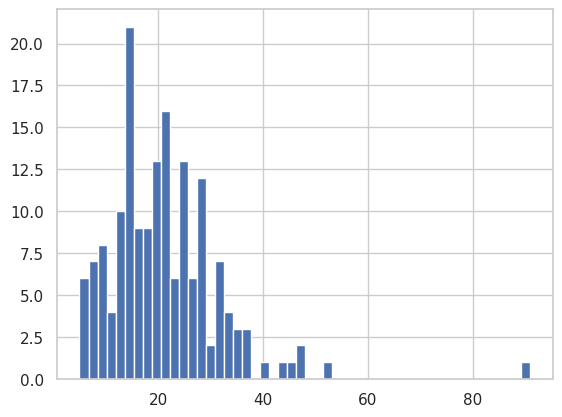

In [ ]:
%matplotlib inline
plt.hist([len(s) for s in df_group['Entitas Index']], bins=50) # sentence length histogram
plt.show()

In [ ]:
def get_pad_train_dev(df_group, train_df):

    #Pad tokens (X var)
    tokens = df_group['Entitas Index'].tolist()
    maxlen = max([len(s) for s in df_group['Entitas Index']])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', value= token2idx[""])

    #Pad Tags (y var) and convert it into one hot encoding
    tags = df_group['Label Index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags_ = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train and dev set
    train_tokens, dev_tokens, train_tags, dev_tags = train_test_split(pad_tokens, pad_tags_, test_size = 0.3, train_size =0.7, random_state=1)

    print(
        'train_tokens length:', len(train_tokens),
        '\ndev_tokens length:', len(dev_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ndev_tags:', len(dev_tags),
    )

    return np.array(train_tokens), np.array(dev_tokens), np.array(train_tags), np.array(dev_tags)

train_tokens_, dev_tokens_, train_tags_, dev_tags_ = get_pad_train_dev(df_group, train_df)

train_tokens length: 116 
dev_tokens length: 50 
train_tags: 116 
dev_tags: 50


In [ ]:
print(np.array(train_tokens_))

[[  0   0   0 ... 459 356 445]
 [  0   0   0 ... 572 398  62]
 [  0   0   0 ... 184 391 435]
 ...
 [  0   0   0 ...  49 457 560]
 [  0   0   0 ... 507  57 412]
 [  0   0   0 ... 585 253  79]]


In [ ]:
[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[59], train_tags_[59]) if idx2token[x]]

[('ingredients', 'O'),
 ('water', 'B-ingredients'),
 ('wheat', 'B-ingredients'),
 ('starch', 'I-ingredients'),
 ('tapiocca', 'B-ingredients'),
 ('corn', 'B-ingredients'),
 ('starch', 'I-ingredients'),
 ('sugar', 'B-ingredients'),
 ('crab', 'B-ingredients'),
 ('extract', 'I-ingredients'),
 ('salt', 'B-ingredients'),
 ('soybean', 'B-ingredients'),
 ('protein', 'B-ingredients'),
 ('rice', 'I-ingredients'),
 ('wine', 'B-ingredients'),
 ('water', 'I-ingredients'),
 ('glutinous', 'B-ingredients'),
 ('rice', 'I-ingredients'),
 ('soybean', 'B-ingredients'),
 ('oil', 'I-ingredients'),
 ('crab', 'B-ingredients'),
 ('flavor', 'I-ingredients'),
 ('paprika', 'B-ingredients')]

In [ ]:
input_dim = len(list(set(train_df['Entitas'].to_list())))+1 # vocab length + padding
output_dim = 64
input_length = train_tokens_.shape[1] # max example length
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  681 
output_dim:  64 
input_length:  91 
n_tags:  4


In [ ]:
# !gzip -d /content/drive/MyDrive/fasttext/cc.en.300.bin.gz

In [ ]:
# !pwd

In [ ]:
 # This takes ~2 mins.
#  import time
 %time embeddings = fasttext.load_model('/content/drive/MyDrive/fasttext/cc.en.300.bin')

CPU times: user 2.2 s, sys: 9.42 s, total: 11.6 s
Wall time: 2min 57s


#batas

In [ ]:
def get_subword_embeddings(word, embeddings):
    subwords = [word[i:i+2] for i in range(len(word)-1)]
    subword_vectors = []
    for subword in subwords:
        subword_vector = embeddings.get_word_vector(subword)
        subword_vectors.append(subword_vector)
        print(f"Subword: {subword}, Vector: {subword_vector[:10]}")  # Print first 10 dimensions for brevity
    word_embedding = np.mean(subword_vectors, axis=0)
    return word_embedding

for word, i in token2idx.items():
    embedding_vector = get_subword_embeddings(word, embeddings)
    if embedding_vector is not None and isinstance(embedding_vector, np.ndarray) and embedding_vector.shape[0] == embeddings.get_dimension():
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
    if isinstance(embedding_vector, np.ndarray):
        print(f"Word: {word}, Embedding: {embedding_vector[:10]}")  # Print first 10 dimensions for brevity
    else:
        print(f"Word: {word}, Embedding: None")  # Indicate if embedding_vector is not valid

print("Converted %d words (%d misses)" % (hits, misses))


Streaming output truncated to the last 5000 lines.
 -0.26694784  0.08608536 -0.17172332  0.00393005]
Subword: e9, Vector: [ 0.33675572 -0.46163744 -0.2869521  -0.56294686  0.843925    0.49769315
 -0.27409697  0.07561202 -0.03187161  0.6101062 ]
Subword: 90, Vector: [-0.19152571  0.0891152  -0.34377736 -0.16744678  0.12389905 -0.05887217
 -0.4644097  -0.03806709 -0.07722174 -0.15155168]
Subword: 00, Vector: [ 0.11831766 -0.09330971  0.02989511 -0.413567    0.04823471  0.31549117
 -0.41098952  0.22897676  0.26576135  0.23311043]
Word: e900, Embedding: [ 0.08784922 -0.15527731 -0.2002781  -0.38132024  0.33868626  0.2514374
 -0.3831654   0.08884057  0.05222267  0.230555  ]
Subword: e2, Vector: [ 0.6417706   0.10117482 -0.6894909  -0.12145856  0.48053223  0.39658347
 -0.4670768  -0.0561473  -0.37612057  0.00545625]
Subword: 22, Vector: [ 0.16291462  0.15333174  0.08470796 -0.3996567   0.27623394 -0.07666852
 -0.19086222  0.23184103 -0.08078849  0.00270234]
Subword: 24, Vector: [ 0.24723342 

#batas

In [ ]:
# Prepare embedding matrix
hits = misses = 0 # in case of FastText all tokens should be covered
embedding_matrix = np.zeros((len(token2idx), embeddings.get_dimension()))
for word, i in token2idx.items():
    embedding_vector = embeddings[word]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
    print(f"Word: {word}, Embedding: {embedding_vector[:10]}")  # Print first 10 dimensions for brevity
print("Converted %d words (%d misses)" % (hits, misses))

Word: , Embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Word: e575, Embedding: [-0.02654687 -0.02133441 -0.0576057   0.04283941 -0.04278423 -0.01766705
 -0.07756041  0.02542077  0.05301751 -0.01434419]
Word: e1505, Embedding: [ 0.03479373 -0.00694542 -0.14119898  0.00768655  0.07221337  0.0153602
 -0.06577709  0.08008452 -0.04242044 -0.11451301]
Word: bicarbonate, Embedding: [-0.03713053  0.04207909 -0.07806521 -0.01228542  0.01118598 -0.02730802
  0.0294958   0.01509581  0.03469607 -0.02783092]
Word: melted, Embedding: [-0.01534587  0.01797373 -0.02631344  0.04310183  0.02065802 -0.03109801
  0.00180441  0.03288056 -0.01228036 -0.01359012]
Word: e412, Embedding: [ 0.01939928 -0.08631845 -0.032498    0.10690937 -0.0042092  -0.03322927
 -0.01134142 -0.02631348  0.00189489 -0.02229998]
Word: gluten, Embedding: [ 0.02606795 -0.01987691 -0.09242157  0.09412305  0.01291115 -0.10433795
  0.10572731  0.02789147 -0.01581649 -0.01790545]
Word: asiago, Embedding: [ 0.0126711  -0.09688109 -0.04571325 

In [ ]:
tag2idx

{'': 0, 'B-ingredients': 1, 'I-ingredients': 2, 'O': 3}

In [ ]:
input_length

91

In [ ]:
model1 = Sequential()

# Add Embedding layer
model1.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(), input_length=input_length, embeddings_initializer=Constant(embedding_matrix), trainable=True, mask_zero=True))
#model1.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, trainable=True, mask_zero=True))

model1.add(Dropout(0.5))
# Add BiLSTM
model1.add(Bidirectional(LSTM(units=input_dim*2, return_sequences=True), merge_mode = 'concat'))

model1.add(Dropout(0.5))
model1.add(LSTM(units=input_dim, return_sequences=True))

# Add timeDistributed Layer
model1.add(TimeDistributed(Dense(n_tags, activation="softmax")))

#Optimiser
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Compile model1
hist = model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
len(train_tokens_)

116

In [ ]:
hist1 = model1.fit(train_tokens_, train_tags_, batch_size=16, verbose=1, epochs=5, validation_data=(dev_tokens_, dev_tags_))

Epoch 1/5


OperatorNotAllowedInGraphError: Exception encountered when calling TimeDistributed.call().

[1mUsing a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(None, 91, 681), dtype=float32)
  • training=True
  • mask=tf.Tensor(shape=(None, 91), dtype=bool)

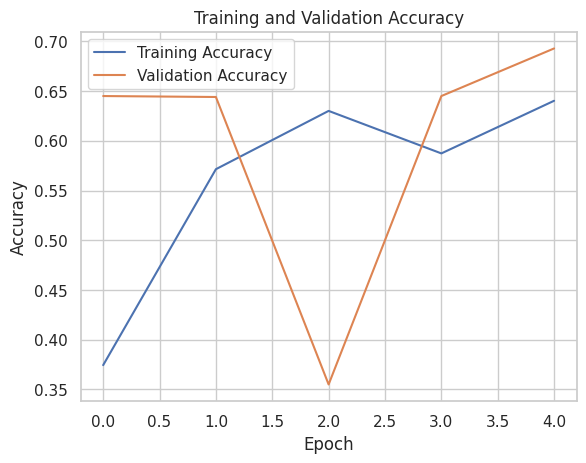

In [ ]:
# Membuat grafik untuk kurva akurasi
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

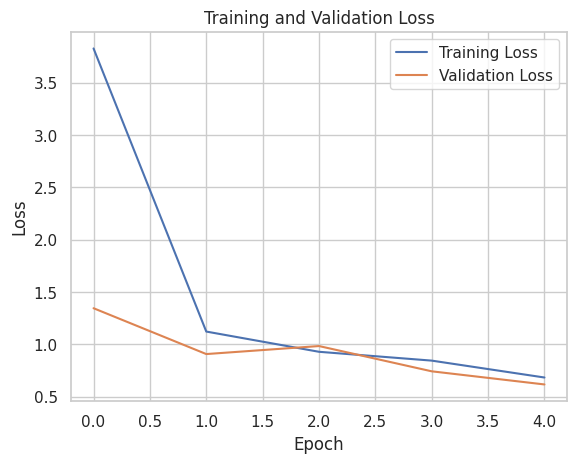

In [ ]:
# Membuat grafik untuk kurva loss
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant


model2 = Sequential()
model2.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(),
                     input_length=input_length, embeddings_initializer=Constant(embedding_matrix),
                     trainable=True, mask_zero=False))
model2.add(Dropout(0.5))
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(units=output_dim, return_sequences=True,
                              kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
                         merge_mode='concat'))
model2.add(Dropout(0.5))
model2.add(TimeDistributed(Dense(n_tags, activation="softmax")))
adam = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Assuming you have a fit statement like this
hist2 = model2.fit(train_tokens_, train_tags_, epochs=100, batch_size=32, validation_data=(dev_tokens_, dev_tags_))

Epoch 1/100
4/4 [==============================] - 8s 571ms/step - loss: 3.7039 - accuracy: 0.6539 - val_loss: 3.5099 - val_accuracy: 0.8952
Epoch 2/100
4/4 [==============================] - 1s 232ms/step - loss: 3.4041 - accuracy: 0.8726 - val_loss: 3.1765 - val_accuracy: 0.8923
Epoch 3/100
4/4 [==============================] - 1s 293ms/step - loss: 3.0378 - accuracy: 0.8741 - val_loss: 2.7132 - val_accuracy: 0.8831
Epoch 4/100
4/4 [==============================] - 1s 273ms/step - loss: 2.5318 - accuracy: 0.8684 - val_loss: 2.1481 - val_accuracy: 0.8714
Epoch 5/100
4/4 [==============================] - 1s 193ms/step - loss: 2.0585 - accuracy: 0.8588 - val_loss: 1.8671 - val_accuracy: 0.8679
Epoch 6/100
4/4 [==============================] - 1s 180ms/step - loss: 1.8320 - accuracy: 0.8628 - val_loss: 1.6897 - val_accuracy: 0.8835
Epoch 7/100
4/4 [==============================] - 1s 176ms/step - loss: 1.6622 - accuracy: 0.8742 - val_loss: 1.5502 - val_accuracy: 0.8952
Epoch 8/100
4

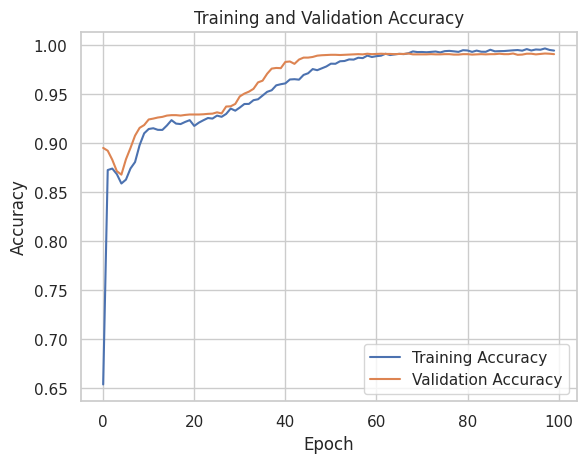

In [ ]:
# Membuat grafik untuk kurva akurasi
plt.plot(hist2.history['accuracy'], label='Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

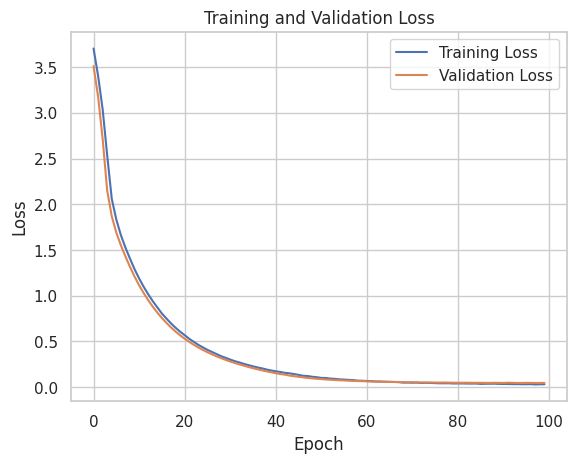

In [ ]:
# Membuat grafik untuk kurva loss
plt.plot(hist2.history['loss'], label='Training Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# hist2 = model2.fit(train_tokens_, train_tags_, epochs=100, batch_size=32, validation_data=(dev_tokens_, dev_tags_))
from sklearn.metrics import classification_report

# Make predictions
predictions = model2.predict(train_tokens_)

# Convert predictions and test labels to categorical labels
pred_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(train_tags_, axis=-1)

# Flatten the labels
pred_labels_flat = pred_labels.flatten()
true_labels_flat = true_labels.flatten()

# Generate classification report
report = classification_report(true_labels_flat, pred_labels_flat)
print(report)

4/4 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       776
           2       1.00      1.00      1.00      1566
           3       1.00      1.00      1.00      8214

    accuracy                           1.00     10556
   macro avg       1.00      1.00      1.00     10556
weighted avg       1.00      1.00      1.00     10556



In [ ]:
# model1.save("model1")
model2.save("model")

In [ ]:
# Load the models
model1.save('model1.h5')
model2.save('model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
np.save('idx2token.npy', idx2token)
np.save('idx2tag.npy', idx2tag)

In [ ]:
# Save wordidx, maxlen, tagidx to NPY files
np.save('wordidx.npy', token2idx)
np.save('maxlen.npy', input_length)
np.save('tagidx.npy', tag2idx)
np.save('idx2token.npy', idx2token)
np.save('idx2tag.npy', idx2tag)

token2idx, idx2token = get_dict_map(train_df, 'token')
tag2idx, idx2tag = get_dict_map(train_df, 'tag')

In [ ]:
i = 0

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(train_tokens_, train_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model1.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 4s 4s/step
[('ingredients', 'O', 'O'), ('corn', 'B-ingredients', 'B-ingredients'), ('grits', 'I-ingredients', 'B-ingredients'), ('palm', 'B-ingredients', 'B-ingredients'), ('oilen', 'I-ingredients', 'B-ingredients'), ('oil', 'I-ingredients', 'B-ingredients'), ('roasted', 'B-ingredients', 'B-ingredients'), ('corn', 'I-ingredients', 'B-ingredients'), ('seasoning', 'I-ingredients', 'B-ingredients'), ('hydrolyzed', 'B-ingredients', 'B-ingredients'), ('vegetable', 'I-ingredients', 'B-ingredients'), ('protein', 'I-ingredients', 'B-ingredients'), ('monosodium', 'B-ingredients', 'B-ingredients'), ('glutamate', 'I-ingredients', 'B-ingredients'), ('disodium', 'B-ingredients', 'B-ingredients'), ('glutamate', 'I-ingredients', 'B-ingredients'), ('disodium', 'B-ingredients', 'B-ingredients'), ('guanylate', 'I-ingredients', 'B-ingredients'), ('wheat', 'B-ingredients', 'B-ingredients'), ('allergen', 'B-ingredients', 'B-ingredients')]
1/1 [========================

In [ ]:
i = 10

#[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

for sample, annotation in zip(dev_tokens_, dev_tags_):
  ex=sample.reshape((1, sample.shape[0]))
  prediction = model2.predict(ex)
  ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
  print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
  i += 1
  if i == 10:
    break

1/1 [==============================] - 0s 116ms/step
[('ingredients', 'O', 'O'), ('wheat', 'B-ingredients', 'B-ingredients'), ('flour', 'I-ingredients', 'I-ingredients'), ('tapioca', 'B-ingredients', 'B-ingredients'), ('starch', 'I-ingredients', 'I-ingredients'), ('vegetable', 'B-ingredients', 'B-ingredients'), ('oil', 'I-ingredients', 'I-ingredients'), ('spicy', 'B-ingredients', 'B-ingredients'), ('chilli', 'I-ingredients', 'B-ingredients'), ('seasoning', 'I-ingredients', 'I-ingredients'), ('chilli', 'B-ingredients', 'B-ingredients'), ('powder', 'I-ingredients', 'I-ingredients'), ('monosodium', 'B-ingredients', 'B-ingredients'), ('glutamate', 'I-ingredients', 'I-ingredients'), ('sugar', 'B-ingredients', 'B-ingredients'), ('salt', 'B-ingredients', 'B-ingredients'), ('acidity', 'B-ingredients', 'B-ingredients'), ('regulator', 'I-ingredients', 'B-ingredients'), ('potassium', 'B-ingredients', 'B-ingredients'), ('carbonate', 'I-ingredients', 'I-ingredients')]
1/1 [=========================

In [ ]:
my_sentence = "Greek salad is made with cucumbers e621 tomatoes red onions feta cheese olives olive oil and oregano"
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model2.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Greek', 'salad', 'is', 'made', 'with', 'cucumbers', 'feta', 'olives', 'and']
1/1 [==============================] - 3s 3s/step
[('Greek', 'O'), ('salad', 'O'), ('is', 'O'), ('made', 'O'), ('with', 'O'), ('cucumbers', 'O'), ('e621', 'O'), ('tomatoes', 'B-ingredients'), ('red', 'B-ingredients'), ('onions', 'B-ingredients'), ('feta', 'B-ingredients'), ('cheese', 'B-ingredients'), ('olives', 'B-ingredients'), ('olive', 'B-ingredients'), ('oil', 'I-ingredients'), ('and', 'B-ingredients'), ('oregano', 'O')]
